| **Chapter**                   | 6:  Simple compartmental models              |
| ----------------------------- |----------------------------------------------|
| **Computational Note**        | 6.1: Targeted vaccination                    |
| **Package prerequisites**     | [SymPy](https://www.sympy.org/en/index.html) |


# Targeted vaccination

In this example, we use SymPy to model a risk-stratified model with the WAIFW matrix

$$
    \beta = \begin{pmatrix}
        10 & 0.5 \\
        0.5 & 2.0
    \end{pmatrix}
$$

and a 20\% population share belonging to the high-risk group.

In [1]:
import numpy as np
from sympy.interactive.printing import init_printing
init_printing(use_unicode=True, wrap_line=True)
from sympy.matrices import Matrix
from sympy import symbols
from sympy import lambdify
from matplotlib import pyplot as plt

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p sympy

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

sympy: 1.10.1

numpy     : 1.22.4
matplotlib: 3.5.2



## Defining the $\beta$ matrix

In [3]:
beta = np.array([[10., 0.5],[0.5, 2.0]])

## Defining symbols for SymPy

In [4]:
I_H, I_L, beta_HH, beta_HL, beta_LH, beta_LL, gamma_H, gamma_L, n_H, n_L, v_H, v_L = symbols("I_H I_L beta_HH beta_HL beta_LH beta_LL gamma_H gamma_L n_H n_L v_H v_L")

## Calculating the Jacobian of the infectious system

In [5]:
infectious_system = Matrix(np.array([I_H, I_L]).T)

In [6]:
d_Is = Matrix(np.array([(beta_HH * n_H - gamma_H) * I_H + (beta_HL * n_H) * I_L,
                        beta_LH * n_L * I_H + (beta_LL * n_L - gamma_L) * I_L]).T)

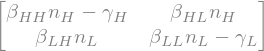

In [7]:
coeffs = d_Is.jacobian(infectious_system)
coeffs

## Calculating the eigenvalues of the Jacobian

We use the `subs` method of the Jacobian to substitute values for symbols, then calculate the eigenvalues for a grid of values of $\nu_H$ and $\nu_L$ (vaccination rates of the high and low risk cohort, respectively):

* `beta_` variables are taken from the WAIFW matrix $\beta$,
* `gamma_` variables are invariant between the two groups, since both recover with equal probability (0.05/day)
* initial values of $N$ for H and L are set at 0.2 and 0.8, respectively.

In [8]:
nx, ny = (100, 100)
x = np.linspace(0.01, 1, nx)
y = np.linspace(0.01, 1, ny)
xx, yy = np.meshgrid(x, y)

In [9]:
f = lambdify([v_H, v_L], coeffs.subs({"beta_HH": 10,
                 "beta_HL": 0.5,
                 "beta_LH": 0.5,
                 "beta_LL": 2,  
                 "n_H": 0.2 * (1-v_H),
                 "n_L": 0.8 * (1-v_L),
                 "gamma_H": 0.05,
                 "gamma_L": 0.05}).eigenvals())

## Vectorisation of the spectral radius function

We use the `@np.vectorize` decorator to create a function that we can call on arrays.
The function `get_r0` takes two arguments (the vaccination rates of the high-risk and low-risk cohorts), and substitutes them into the Jacobian.
It then returns the element of the Jacobian with the largest absolute value.

In [10]:
@np.vectorize
def get_r0(v_H, v_L):
    return max([abs(i) for i in f(v_H, v_L)])

## Plotting the results

<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in sqrt
  return {-1.0*v_H - 0.8*v_L - 1.24899959967968*sqrt(0.641025641025641*v_H**2 - 1.0*v_H*v_L - 0.282051282051282*v_H + 0.41025641025641*v_L**2 + 0.179487179487179*v_L + 0.0512820512820513) + 1.75: 1, -1.0*v_H - 0.8*v_L + 1.24899959967968*sqrt(0.641025641025641*v_H**2 - 1.0*v_H*v_L - 0.282051282051282*v_H + 0.41025641025641*v_L**2 + 0.179487179487179*v_L + 0.0512820512820513) + 1.75: 1}
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in get_r0 (vectorized)
  outputs = ufunc(*inputs)


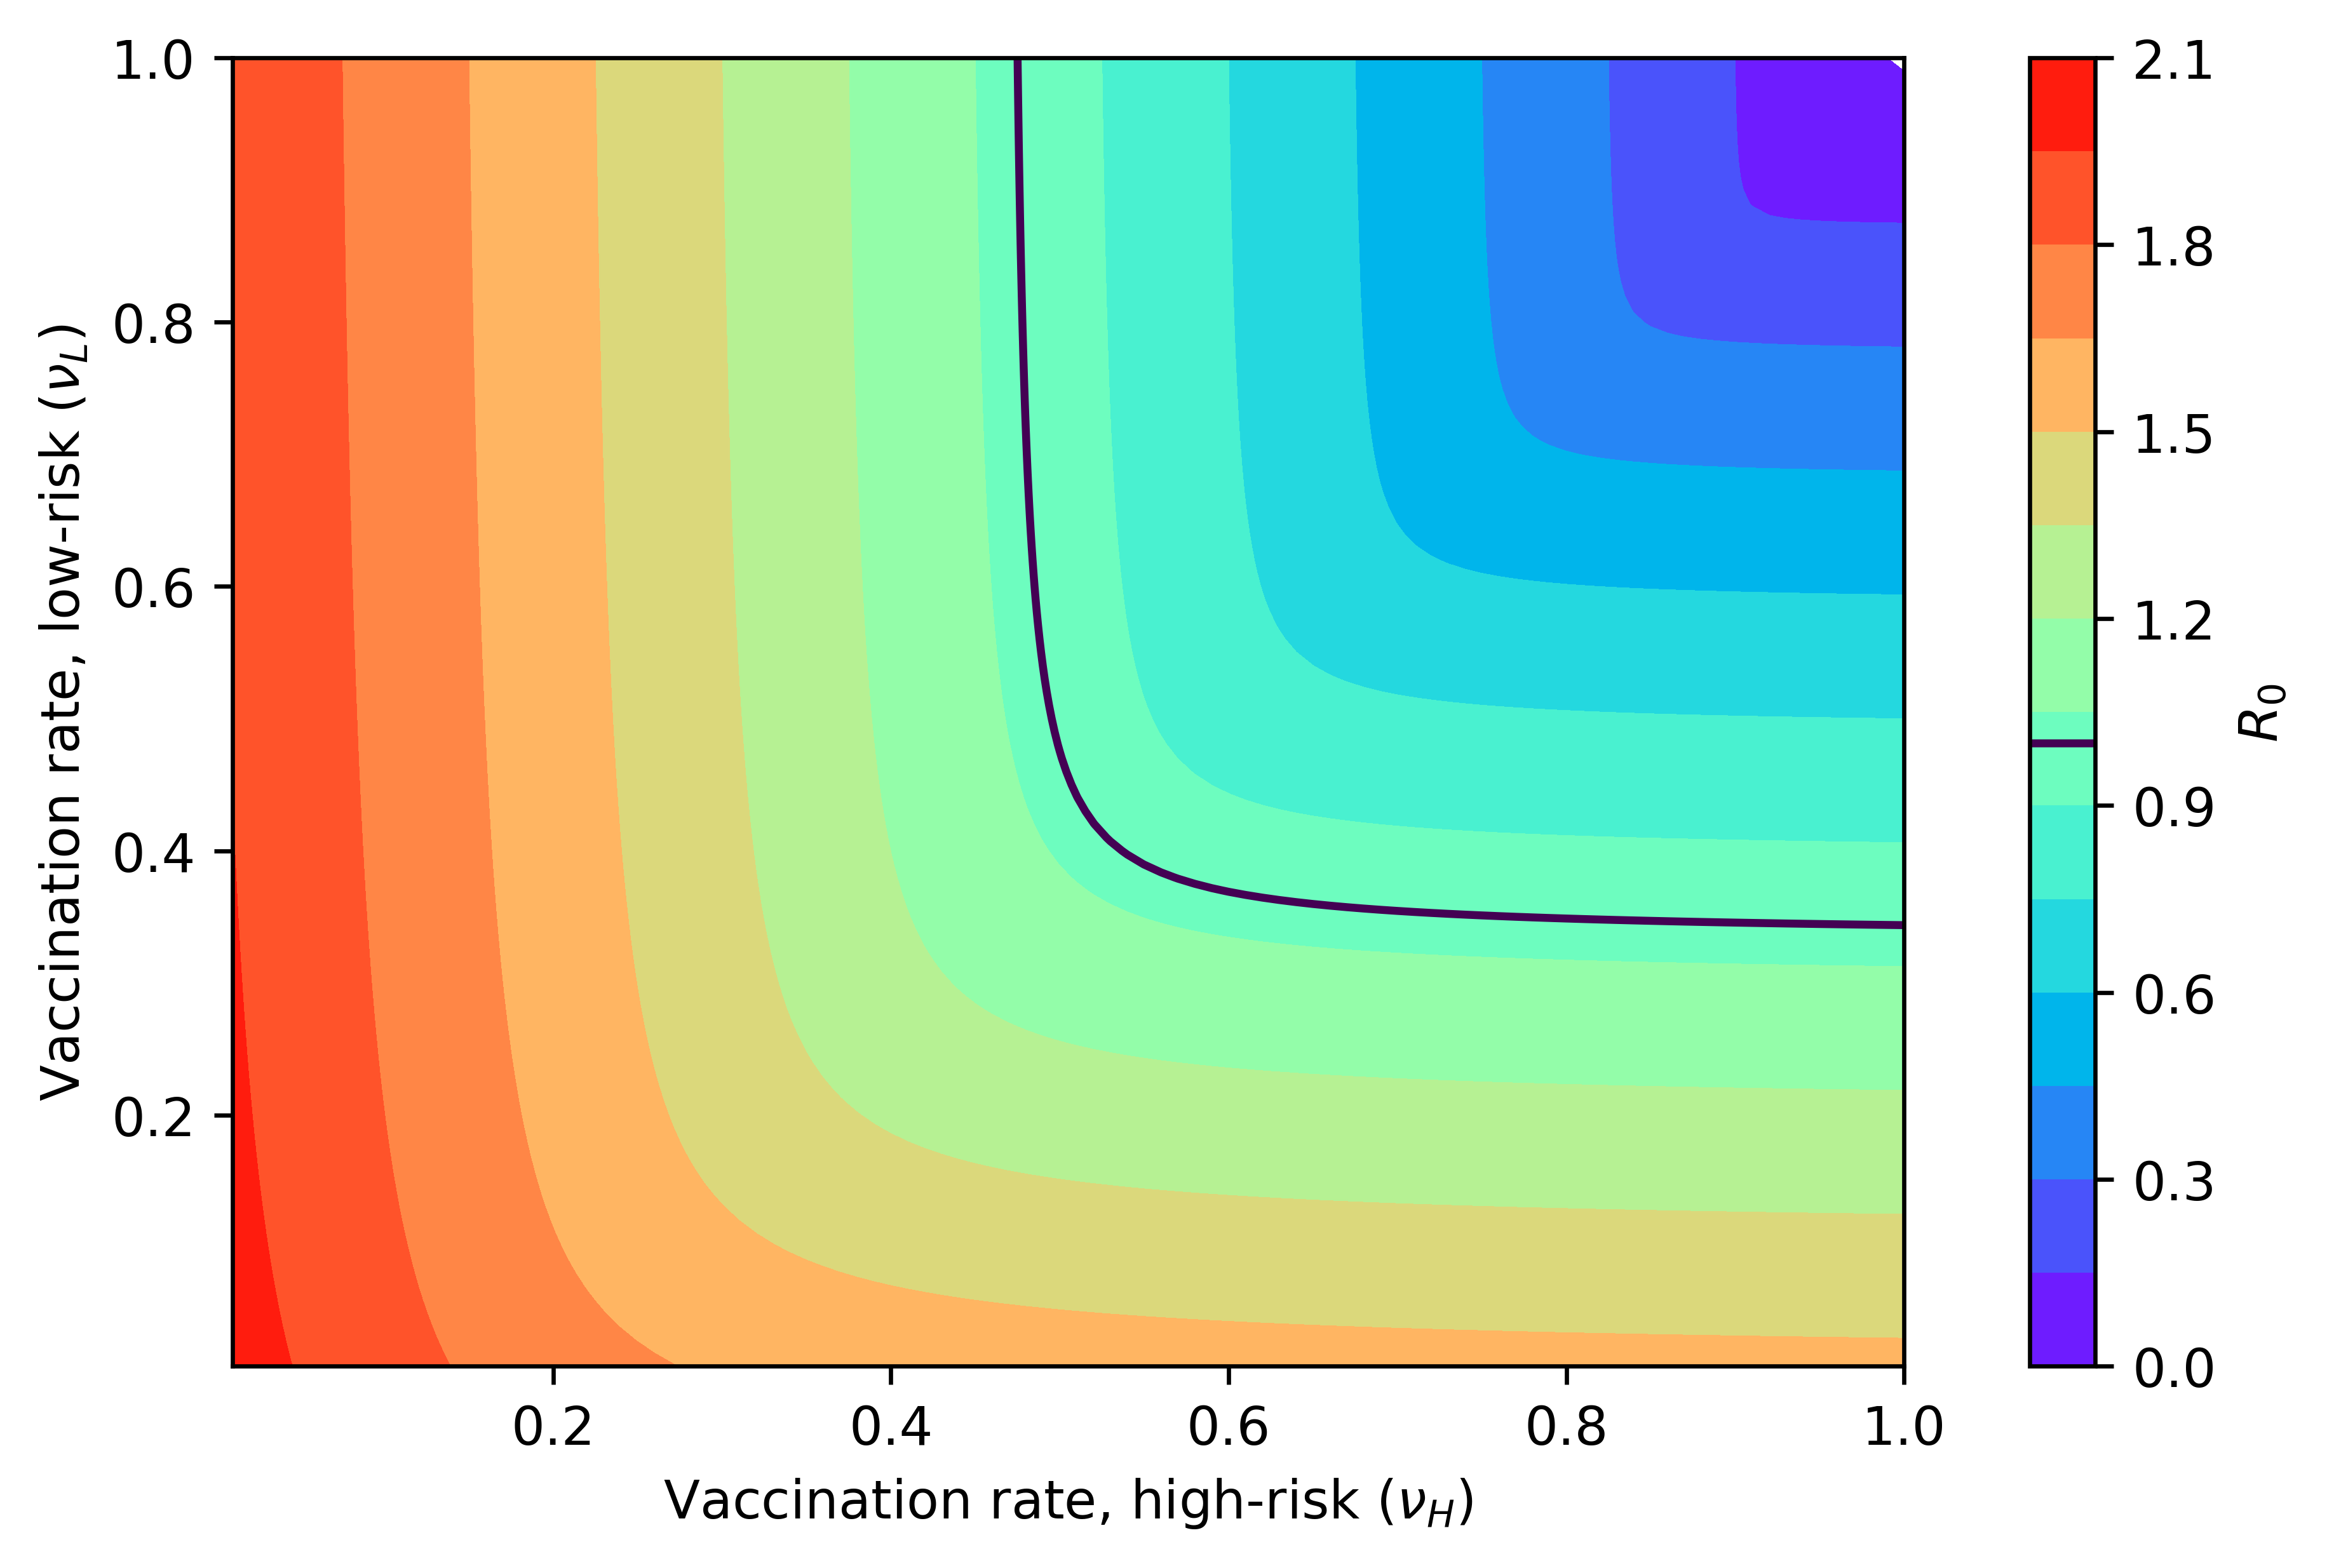

In [11]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4), dpi=600)

origin = "lower"

fill = ax.contourf(xx, yy, get_r0(xx, yy), 15, cmap=plt.cm.rainbow, origin=origin)
critical_optimum = ax.contour(xx, yy, get_r0(xx, yy), levels=[1.0], origin=origin)

ax.set_ylabel("Vaccination rate, low-risk ($\\nu_L$)")
ax.set_xlabel("Vaccination rate, high-risk ($\\nu_H$)")

cbar = fig.colorbar(fill)
cbar.ax.set_ylabel("$R_0$")
cbar.add_lines(critical_optimum)

plt.savefig("risk_dependent_vaccination_optima.pdf")